# Jupyter notebook sample

In [45]:


import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os


In [46]:
face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")

In [47]:
def detect_face(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        return None  # No face detected

    x, y, w, h = faces[0]
    face = image[y:y+h, x:x+w]
    face = cv2.resize(face, (224, 224))
    return face

In [48]:
# Define dataset paths
train_dir = "CK_dataset/train"
test_dir = "CK_dataset/test"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(train_dir, transform=transform)
test_dataset = ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [49]:
# Load ResNet18 model
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 6)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

C:\Users\farha\DataspellProjects\AI_Assignment2\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\farha\DataspellProjects\AI_Assignment2\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [50]:
# Training with Test Accuracy per Epoch
num_epochs = 10
train_acc_list = []
test_acc_list = []
train_loss_list = []
test_loss_list = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_accuracy = 100 * correct / total
    train_acc_list.append(train_accuracy)
    train_loss_list.append(running_loss / len(train_loader))

    # Evaluate on Test Set after each epoch
    model.eval()
    correct_test = 0
    total_test = 0
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total_test += labels.size(0)
            correct_test += predicted.eq(labels).sum().item()
    test_accuracy = 100 * correct_test / total_test
    test_acc_list.append(test_accuracy)
    test_loss_list.append(test_loss / len(test_loader))
    print(
        f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, '
        f'Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%'
    )


    # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')

Epoch [1/10], Loss: 1.4774, Train Accuracy: 42.23%, Test Accuracy: 43.36%
Epoch [2/10], Loss: 0.5865, Train Accuracy: 84.46%, Test Accuracy: 58.74%
Epoch [3/10], Loss: 0.2897, Train Accuracy: 94.43%, Test Accuracy: 59.44%
Epoch [4/10], Loss: 0.1497, Train Accuracy: 98.24%, Test Accuracy: 60.84%
Epoch [5/10], Loss: 0.0819, Train Accuracy: 99.12%, Test Accuracy: 61.54%
Epoch [6/10], Loss: 0.0372, Train Accuracy: 100.00%, Test Accuracy: 60.84%


KeyboardInterrupt: 

Final Test Accuracy: 50.91%


<Figure size 800x600 with 0 Axes>

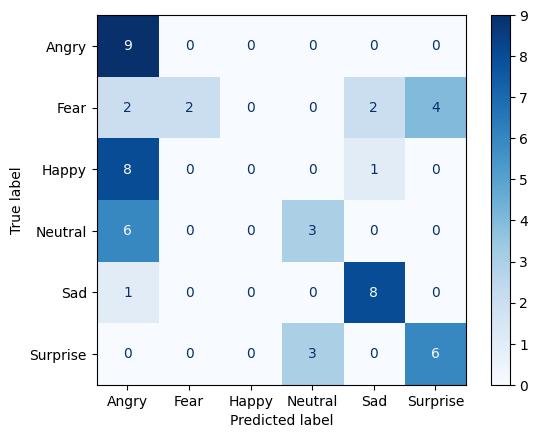

In [33]:
# Final Evaluation and Confusion Matrix
model.eval()
y_true = []
y_pred = []
total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

final_test_accuracy = 100 * correct / total
print(f'Final Test Accuracy: {final_test_accuracy:.2f}%')

conf_matrix = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(conf_matrix, display_labels=test_dataset.classes)

plt.figure(figsize=(8, 6))
cm_display.plot(cmap=plt.cm.Blues)
plt.show()

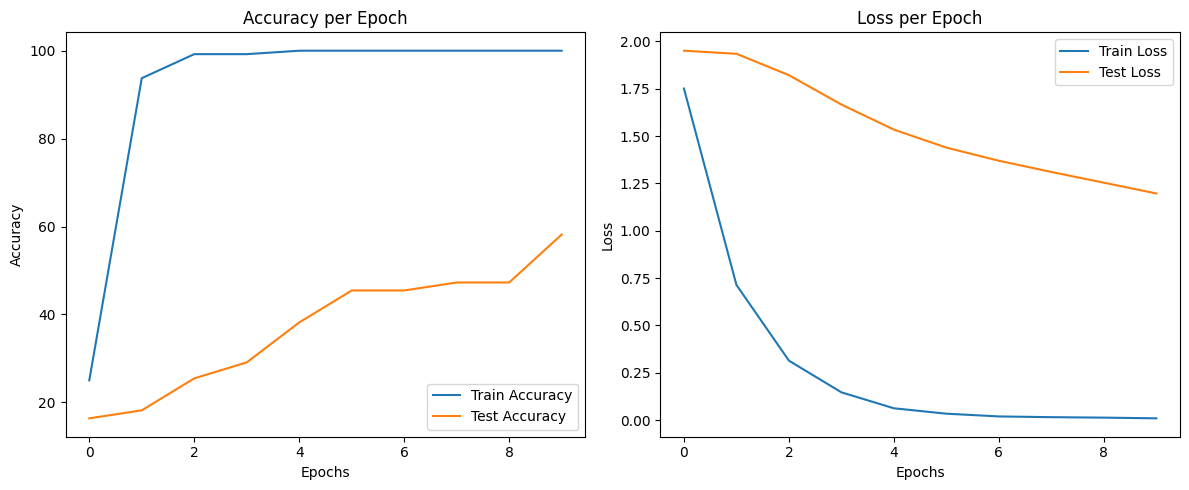

In [38]:
# Plot Accuracy and Loss
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(test_acc_list, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy per Epoch')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(test_loss_list, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss per Epoch')

plt.tight_layout()
plt.show()


C:\Users\farha\AppData\Local\Temp\ipykernel_18556\3079980406.py:97: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


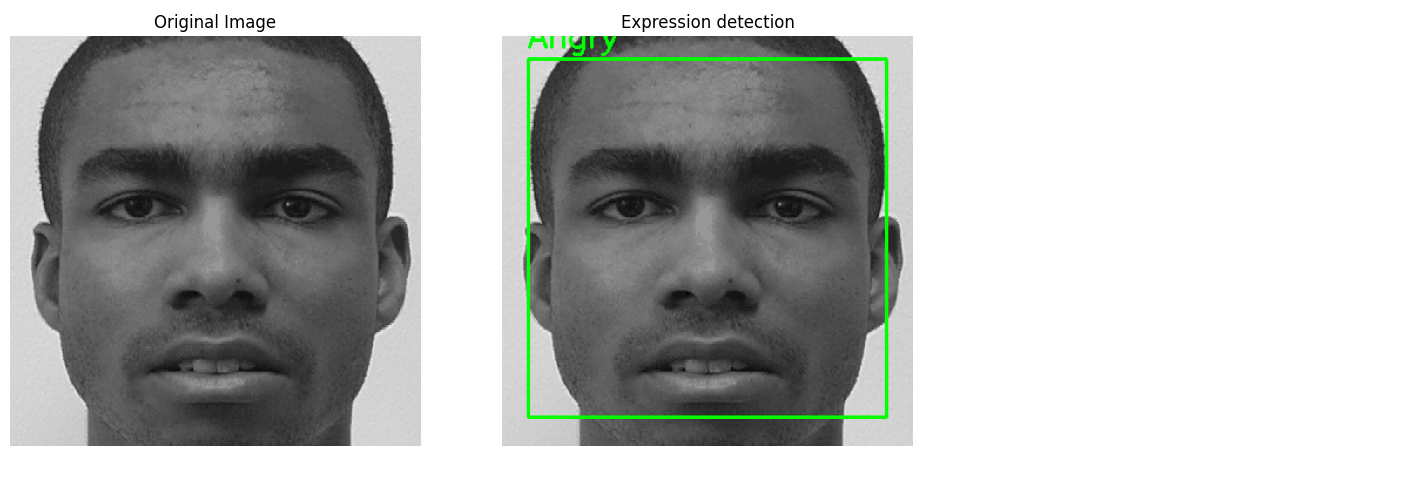

In [39]:
import cv2
import torch
import numpy as np
from matplotlib import pyplot as plt
from torchvision import transforms

# Define a function to predict the emotion
def predict_expression(image, model, device):
    # Detect the face in the image
    face = detect_face(image)
    if face is None:
        return None, None  # No face detected

    # Apply necessary transforms
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    face_tensor = transform(face).unsqueeze(0).to(device)

    # Predict the emotion using the model
    model.eval()
    with torch.no_grad():
        outputs = model(face_tensor)
        _, predicted = torch.max(outputs, 1)

    # Convert predicted label to the corresponding emotion
    emotion = train_dataset.classes[predicted.item()]
    return emotion, face

# Define function to draw bounding box and emotion text for multiple faces
def draw_faces_and_predictions(image, model, device):
    # Convert image to grayscale for face detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        print("No faces detected.")
        return image

    # Loop over all detected faces
    for (x, y, w, h) in faces:
        # Extract the face region from the image
        face = image[y:y+h, x:x+w]

        # Predict the expression of the face
        emotion, _ = predict_expression(face, model, device)
        if emotion is None:
            continue  # If no face is detected, skip

        # Draw the bounding box and the emotion label on the image
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(image, emotion, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    return image

# Test the model with a single image (handling multiple faces)
def test_single_image_multiple_faces(image_path, model, face_cascade, device):
    # Read the image
    image = cv2.imread(image_path)
    image_copy = image.copy()

    # Detect faces and predict emotions
    image_with_predictions = draw_faces_and_predictions(image_copy, model, device)

    # Plot images: Original, Image with bounding boxes, and Image with predictions
    plt.figure(figsize=(18, 6))

    # 1st Image - Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    # 2nd Image - Image with bounding boxes and predictions
    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(image_with_predictions, cv2.COLOR_BGR2RGB))
    plt.title('Expression detection')
    plt.axis('off')

    # 3rd Image - Image with predicted emotions (showing a close-up of one of the faces)
    # Choose one face to show the close-up of (just for demonstration purposes)
    # if len(faces) > 0:
    #     x, y, w, h = faces[0]  # Just show the first detected face
    #     face = image[y:y+h, x:x+w]
    #     plt.subplot(1, 3, 3)
    #     plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
    #     plt.title(f'Predicted Emotion: {emotion}')
    #     plt.axis('off')
    # else:
    plt.subplot(1, 2, 2)
    # plt.text(0.5, 0.5, 'No faces detected in the image', ha='center', va='center', fontsize=12)
    plt.axis('off')

    plt.tight_layout()
    plt.show()


img_path = 'CK_dataset/test/anger/4.jpg'
# img_path = 'CK_dataset/test/happy/0.jpg'
# img_path = 'CK_dataset/test/sadness/0.jpg'
# img_path = 'CK_dataset/test/surprise/2.jpg'
test_single_image_multiple_faces(img_path, model, face_cascade, device)


In [34]:
train_dir = "JAFFE-[70,30]/train"
test_dir = "JAFFE-[70,30]/test"

train_dataset = ImageFolder(train_dir, transform=transform)
test_dataset = ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [35]:
# Load ResNet18 model
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 6)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

C:\Users\farha\DataspellProjects\AI_Assignment2\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\farha\DataspellProjects\AI_Assignment2\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [36]:
# Training with Test Accuracy per Epoch
num_epochs = 10
train_acc_list = []
test_acc_list = []
train_loss_list = []
test_loss_list = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_accuracy = 100 * correct / total
    train_acc_list.append(train_accuracy)
    train_loss_list.append(running_loss / len(train_loader))

    # Evaluate on Test Set after each epoch
    model.eval()
    correct_test = 0
    total_test = 0
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total_test += labels.size(0)
            correct_test += predicted.eq(labels).sum().item()
    test_accuracy = 100 * correct_test / total_test
    test_acc_list.append(test_accuracy)
    test_loss_list.append(test_loss / len(test_loader))
    print(
        f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, '
        f'Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%'
    )


    # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')

Epoch [1/10], Loss: 1.7508, Train Accuracy: 25.00%, Test Accuracy: 16.36%
Epoch [2/10], Loss: 0.7140, Train Accuracy: 93.75%, Test Accuracy: 18.18%
Epoch [3/10], Loss: 0.3143, Train Accuracy: 99.22%, Test Accuracy: 25.45%
Epoch [4/10], Loss: 0.1470, Train Accuracy: 99.22%, Test Accuracy: 29.09%
Epoch [5/10], Loss: 0.0629, Train Accuracy: 100.00%, Test Accuracy: 38.18%
Epoch [6/10], Loss: 0.0343, Train Accuracy: 100.00%, Test Accuracy: 45.45%
Epoch [7/10], Loss: 0.0198, Train Accuracy: 100.00%, Test Accuracy: 45.45%
Epoch [8/10], Loss: 0.0160, Train Accuracy: 100.00%, Test Accuracy: 47.27%
Epoch [9/10], Loss: 0.0135, Train Accuracy: 100.00%, Test Accuracy: 47.27%
Epoch [10/10], Loss: 0.0098, Train Accuracy: 100.00%, Test Accuracy: 58.18%


Final Test Accuracy: 58.18%


<Figure size 800x600 with 0 Axes>

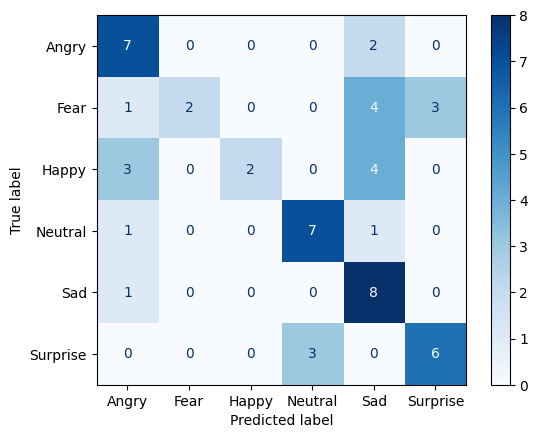

In [37]:
# Final Evaluation and Confusion Matrix
model.eval()
y_true = []
y_pred = []
total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

final_test_accuracy = 100 * correct / total
print(f'Final Test Accuracy: {final_test_accuracy:.2f}%')

conf_matrix = confusion_matrix(y_true, y_pred)
cm_display = ConfusionMatrixDisplay(conf_matrix, display_labels=test_dataset.classes)

plt.figure(figsize=(8, 6))
cm_display.plot(cmap=plt.cm.Blues)
plt.show()

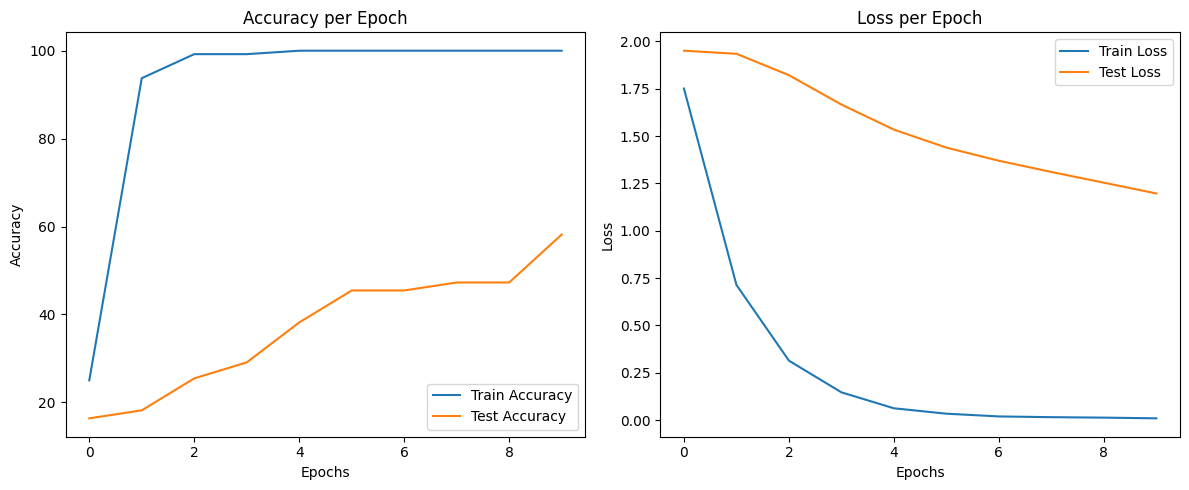

In [43]:
# Plot Accuracy and Loss
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(test_acc_list, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy per Epoch')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(test_loss_list, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss per Epoch')

plt.tight_layout()
plt.show()


In [44]:
import cv2
import torch
import numpy as np
from matplotlib import pyplot as plt
from torchvision import transforms

# Define a function to predict the emotion
def predict_expression(image, model, device):
    # Detect the face in the image
    face = detect_face(image)
    if face is None:
        return None, None  # No face detected

    # Apply necessary transforms
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    face_tensor = transform(face).unsqueeze(0).to(device)

    # Predict the emotion using the model
    model.eval()
    with torch.no_grad():
        outputs = model(face_tensor)
        _, predicted = torch.max(outputs, 1)

    # Convert predicted label to the corresponding emotion
    emotion = train_dataset.classes[predicted.item()]
    return emotion, face

# Define function to draw bounding box and emotion text for multiple faces
def draw_faces_and_predictions(image, model, device):
    # Convert image to grayscale for face detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        print("No faces detected.")
        return image

    # Loop over all detected faces
    for (x, y, w, h) in faces:
        # Extract the face region from the image
        face = image[y:y+h, x:x+w]

        # Predict the expression of the face
        emotion, _ = predict_expression(face, model, device)
        if emotion is None:
            continue  # If no face is detected, skip

        # Draw the bounding box and the emotion label on the image
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(image, emotion, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    return image

# Test the model with a single image (handling multiple faces)
def test_single_image_multiple_faces(image_path, model, face_cascade, device):
    # Read the image
    image = cv2.imread(image_path)
    image_copy = image.copy()

    # Detect faces and predict emotions
    image_with_predictions = draw_faces_and_predictions(image_copy, model, device)

    # Plot images: Original, Image with bounding boxes, and Image with predictions
    plt.figure(figsize=(18, 6))

    # 1st Image - Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    # 2nd Image - Image with bounding boxes and predictions
    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(image_with_predictions, cv2.COLOR_BGR2RGB))
    plt.title('Expression detection')
    plt.axis('off')

    # 3rd Image - Image with predicted emotions (showing a close-up of one of the faces)
    # Choose one face to show the close-up of (just for demonstration purposes)
    # if len(faces) > 0:
    #     x, y, w, h = faces[0]  # Just show the first detected face
    #     face = image[y:y+h, x:x+w]
    #     plt.subplot(1, 3, 3)
    #     plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
    #     plt.title(f'Predicted Emotion: {emotion}')
    #     plt.axis('off')
    # else:
    plt.subplot(1, 2, 2)
    # plt.text(0.5, 0.5, 'No faces detected in the image', ha='center', va='center', fontsize=12)
    plt.axis('off')

    plt.tight_layout()
    plt.show()


img_path = 'FEV_2013/test/happy/PrivateTest_95094.jpg'
# img_path = 'CK_dataset/test/happy/0.jpg'
# img_path = 'CK_dataset/test/sadness/0.jpg'
# img_path = 'CK_dataset/test/surprise/2.jpg'
test_single_image_multiple_faces(img_path, model, face_cascade, device)


AttributeError: 'NoneType' object has no attribute 'copy'